In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.metrics import classification_report, accuracy_score
import itertools

In [2]:
# loading the data
file_path = 'data4JQ.csv'
data = pd.read_csv(file_path)

In [3]:
# summary of data
data_summary = data.describe(include='all')
data_head = data.head()

data_summary, data_head

(                    X              Y            rig  time_lapsed_all  \
 count   377619.000000  377619.000000  377619.000000    377619.000000   
 unique            NaN            NaN            NaN              NaN   
 top               NaN            NaN            NaN              NaN   
 freq              NaN            NaN            NaN              NaN   
 mean         5.457651       5.503550       3.491127      3944.987833   
 std          1.749343       2.082305       1.754350      2532.659088   
 min         -5.670000      -4.470000       1.000000         0.000000   
 25%          4.290000       4.000000       2.000000      1791.676542   
 50%          5.380000       5.530000       3.000000      3697.763174   
 75%          6.960000       7.610000       5.000000      5835.262027   
 max          9.730000      10.510000       6.000000     10147.525980   
 
         pred_lstm23_NV     time  
 count    377613.000000   377619  
 unique             NaN    36000  
 top             

In [4]:
# dropping the 'time' column
data_cleaned = data.drop(columns=['time'])

# checking for and handle missing values
data_cleaned = data_cleaned.dropna()

# display the summary
data_cleaned_summary = data_cleaned.describe(include='all')
data_cleaned_head = data_cleaned.head()

data_cleaned_summary, data_cleaned_head

(                   X              Y            rig  time_lapsed_all  \
 count  377613.000000  377613.000000  377613.000000    377613.000000   
 mean        5.457676       5.503597       3.491127      3945.050515   
 std         1.749329       2.082281       1.754350      2532.630391   
 min        -5.670000      -4.470000       1.000000         0.101038   
 25%         4.290000       4.000000       2.000000      1791.773706   
 50%         5.380000       5.530000       3.000000      3697.774391   
 75%         6.960000       7.610000       5.000000      5835.268600   
 max         9.730000      10.510000       6.000000     10147.525980   
 
        pred_lstm23_NV  
 count   377613.000000  
 mean         0.106429  
 std          0.308386  
 min          0.000000  
 25%          0.000000  
 50%          0.000000  
 75%          0.000000  
 max          1.000000  ,
       X     Y  rig  time_lapsed_all  pred_lstm23_NV
 1  0.79  1.35    1         0.189712             0.0
 2  0.84  1.22    

In [5]:
# Define initial state (location and velocity)
initial_state = [data_cleaned['X'].iloc[0], data_cleaned['Y'].iloc[0], 0, 0]

# Define the state transition matrix (A)
transition_matrix = [[1, 0, 1, 0],
                     [0, 1, 0, 1],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]]

# Define the observation matrix (H)
observation_matrix = [[1, 0, 0, 0],
                      [0, 1, 0, 0]]

# Define the covariance matrices for process noise (Q) and observation noise (R)
transition_covariance = np.eye(4) * 0.01  # Process noise
observation_covariance = np.eye(2) * 0.1  # Measurement noise

# Initialize the Kalman filter
kf = KalmanFilter(transition_matrices=transition_matrix,
                  observation_matrices=observation_matrix,
                  initial_state_mean=initial_state,
                  transition_covariance=transition_covariance,
                  observation_covariance=observation_covariance)

# Extract the observed data for X and Y
observations = data_cleaned[['X', 'Y']].values

# Apply the Kalman filter to estimate the hidden states (location and velocity)
state_estimates, state_covariances = kf.smooth(observations)

# Add the estimated velocity to the data frame for classification purposes
data_cleaned['vx_est'] = state_estimates[:, 2]
data_cleaned['vy_est'] = state_estimates[:, 3]

In [6]:
# Define a simple threshold for classification based on velocity magnitude
velocity_magnitude = np.sqrt(data_cleaned['vx_est']**2 + data_cleaned['vy_est']**2)
velocity_threshold = 0.1  # Adjust this threshold based on your needs
data_cleaned['kalman_classification'] = (velocity_magnitude > velocity_threshold).astype(int)

In [7]:
accuracy = accuracy_score(data_cleaned['pred_lstm23_NV'], data_cleaned['kalman_classification'])

# Compare the Kalman filter classification with the ground truth
print(classification_report(data_cleaned['pred_lstm23_NV'], data_cleaned['kalman_classification']))
print(f'Accuracy: {accuracy:.5f}')

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94    337424
         1.0       0.53      0.31      0.39     40189

    accuracy                           0.90    377613
   macro avg       0.72      0.64      0.67    377613
weighted avg       0.88      0.90      0.88    377613

Accuracy: 0.89709


In [8]:
# Define the range of values for each parameter
R_values = [0.05, 0.1, 0.15]
Q_values = [0.001, 0.005, 0.01]
threshold_values = [0.05, 0.1, 0.15]

# Store the best combination and best accuracy
best_combination = None
best_accuracy = 0

# Loop over all combinations of the parameters
for R, Q, threshold in itertools.product(R_values, Q_values, threshold_values):
    # Initialize the Kalman filter with the current combination of parameters
    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        initial_state_mean=initial_state,
        transition_covariance=np.eye(4) * Q,
        observation_covariance=np.eye(2) * R
    )
    
    # Apply the Kalman filter to estimate the hidden states (location and velocity)
    state_estimates, _ = kf.smooth(observations)
    
    # Calculate velocity and classify
    velocity_magnitude = np.sqrt(state_estimates[:, 2]**2 + state_estimates[:, 3]**2)
    classifications = (velocity_magnitude > threshold).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(data_cleaned['pred_lstm23_NV'], classifications)
    
    # Update the best combination if the current one is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_combination = (R, Q, threshold)

# Output the best combination and corresponding accuracy
print(f'Best combination: R={best_combination[0]}, Q={best_combination[1]}, Threshold={best_combination[2]}')
print(f'Best accuracy: {best_accuracy:.4f}')

Best combination: R=0.15, Q=0.001, Threshold=0.1
Best accuracy: 0.9124


In [9]:
# Define initial state (location and velocity)
initial_state = [data_cleaned['X'].iloc[0], data_cleaned['Y'].iloc[0], 0, 0]

# Define the state transition matrix (A)
transition_matrix = [[1, 0, 1, 0],
                     [0, 1, 0, 1],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]]

# Define the observation matrix (H)
observation_matrix = [[1, 0, 0, 0],
                      [0, 1, 0, 0]]

# Fine-tuned covariance matrices
transition_covariance = np.eye(4) * 0.001  # Lower process noise to assume more precise control
observation_covariance = np.eye(2) * 0.015  # Lower observation noise to assume more accurate measurements

# Initialize the Kalman filter
kf = KalmanFilter(transition_matrices=transition_matrix,
                  observation_matrices=observation_matrix,
                  initial_state_mean=initial_state,
                  transition_covariance=transition_covariance,
                  observation_covariance=observation_covariance)

# Extract the observed data for X and Y
observations = data_cleaned[['X', 'Y']].values

# Apply the Kalman filter to estimate the hidden states (location and velocity)
state_estimates, state_covariances = kf.smooth(observations)

# Add the estimated velocity to the data frame for classification purposes
data_cleaned['vx_est'] = state_estimates[:, 2]
data_cleaned['vy_est'] = state_estimates[:, 3]

# Fine-tuned threshold for classification based on velocity magnitude
velocity_magnitude = np.sqrt(data_cleaned['vx_est']**2 + data_cleaned['vy_est']**2)
velocity_threshold = 0.1  # Lower threshold to be more sensitive to small movements

# Classify using the fine-tuned threshold
data_cleaned['kalman_classification_tuned'] = (velocity_magnitude > velocity_threshold).astype(int)

# Evaluate the fine-tuned model
print("Fine-Tuned Kalman Filter Classification Report:")
print(classification_report(data_cleaned['pred_lstm23_NV'], data_cleaned['kalman_classification_tuned']))

# Calculate and print accuracy
accuracy_tuned = accuracy_score(data_cleaned['pred_lstm23_NV'], data_cleaned['kalman_classification_tuned'])
print(f'Fine-Tuned Accuracy: {accuracy_tuned:.4f}')

Fine-Tuned Kalman Filter Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95    337424
         1.0       0.56      0.30      0.39     40189

    accuracy                           0.90    377613
   macro avg       0.74      0.64      0.67    377613
weighted avg       0.88      0.90      0.89    377613

Fine-Tuned Accuracy: 0.9005


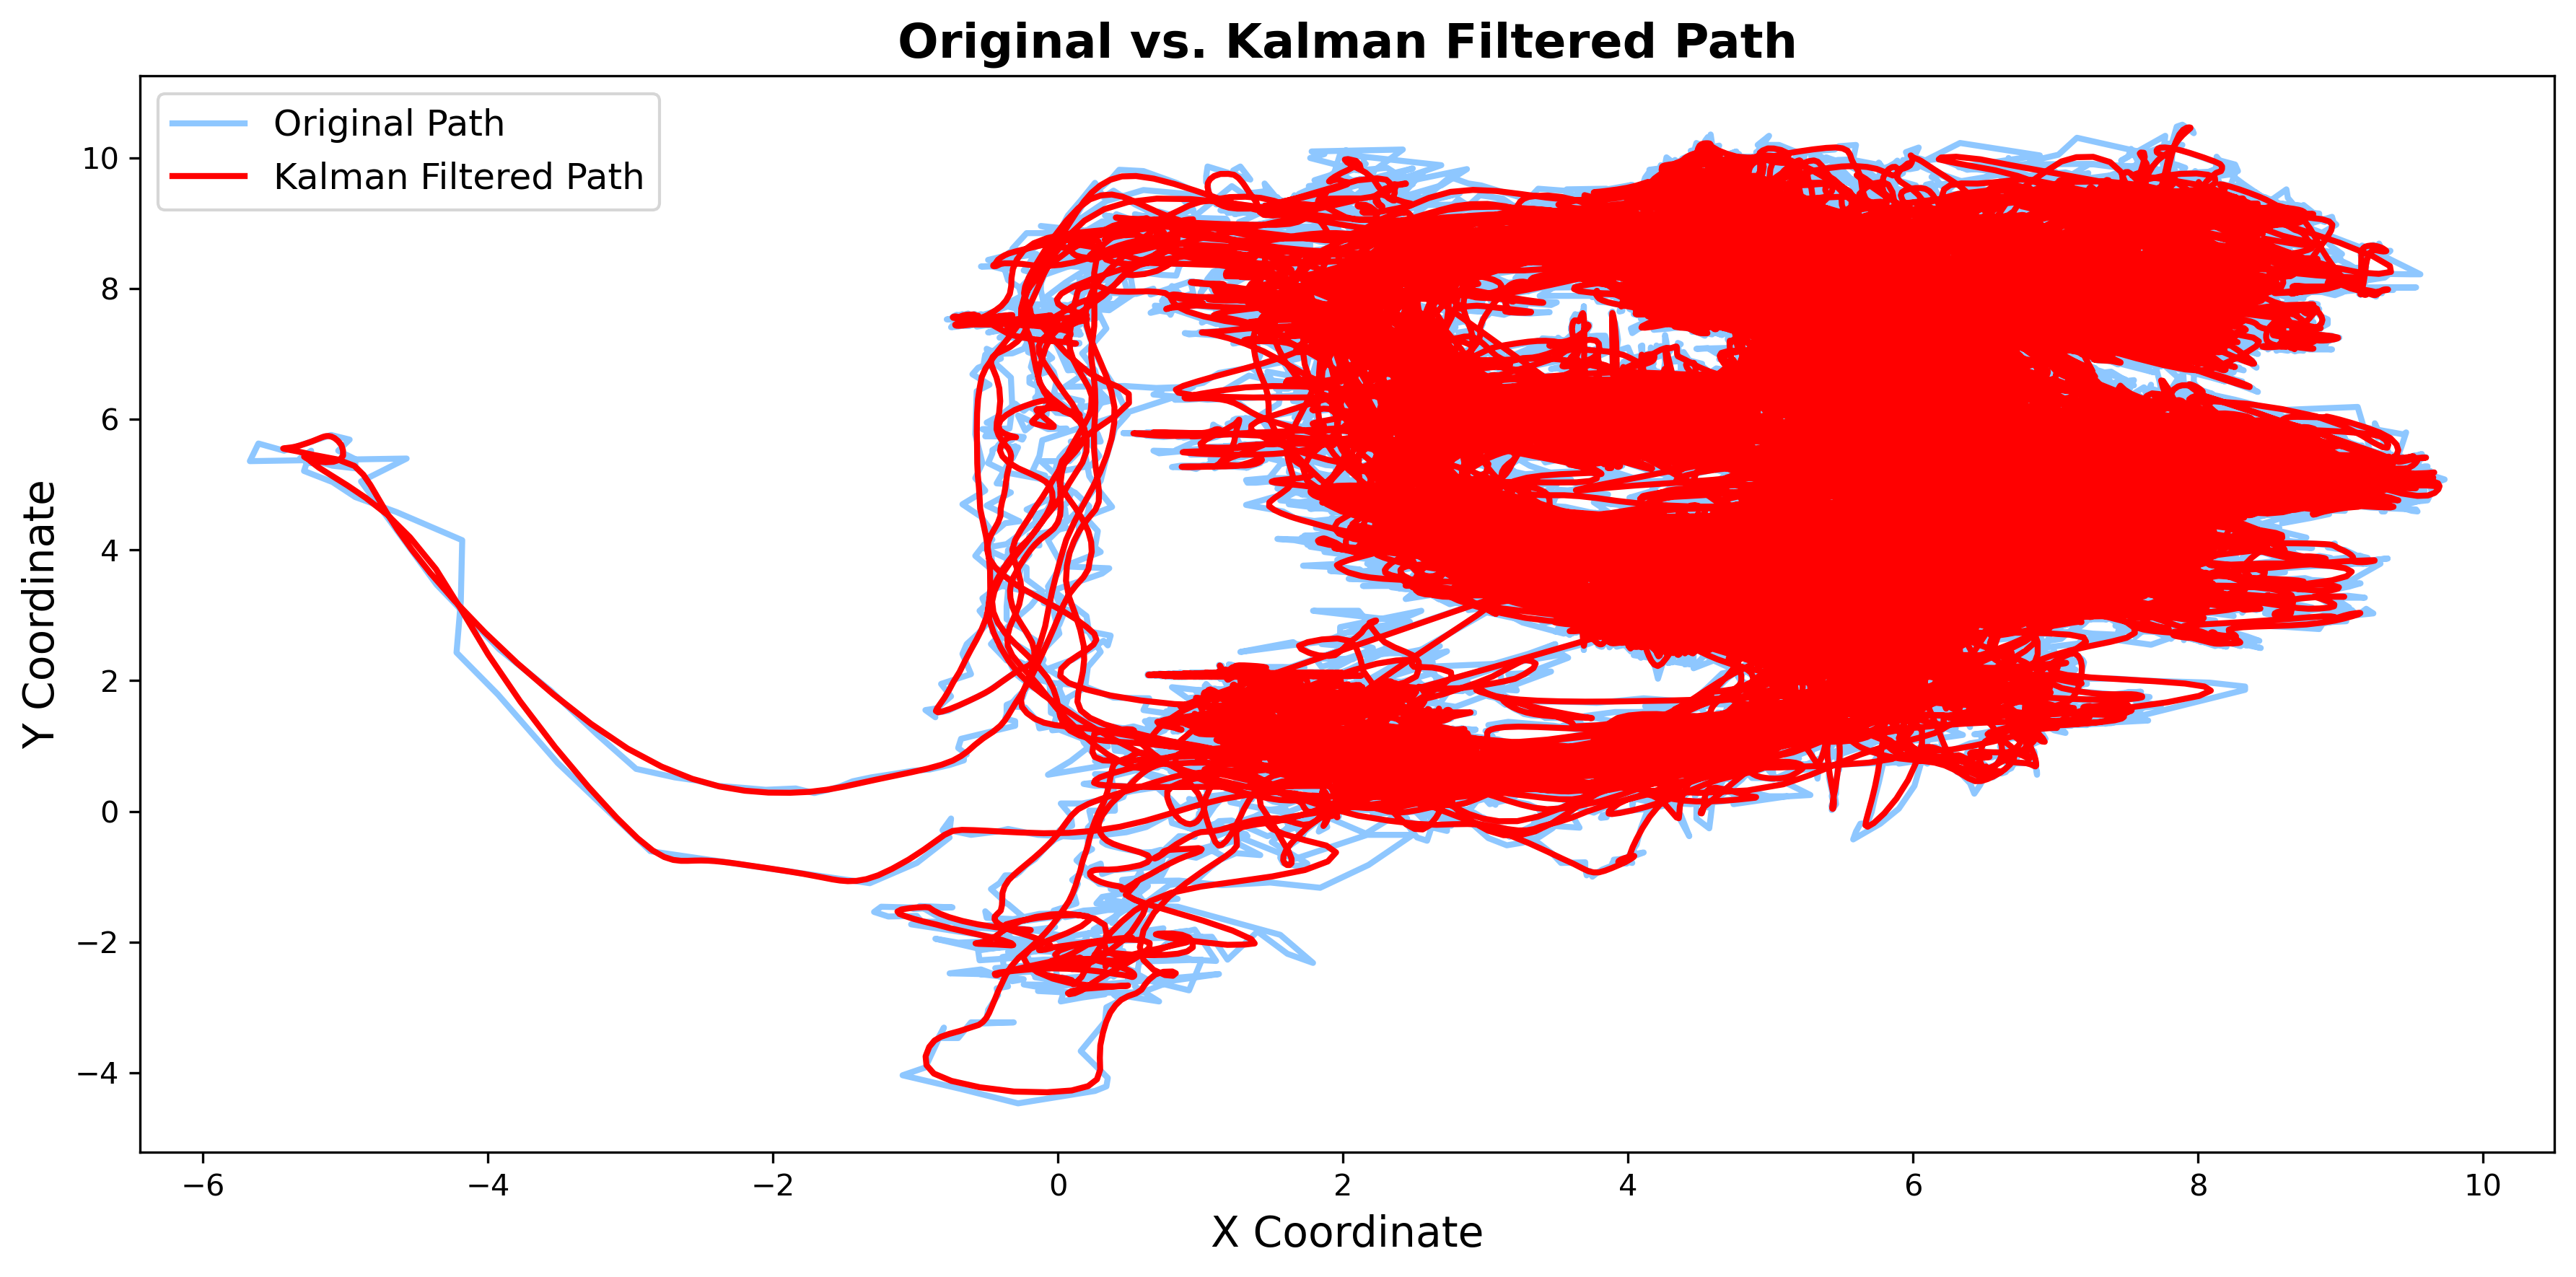

In [11]:
# Plot the original vs. Kalman-filtered positions
plt.figure(figsize=(12, 6), dpi=300)  # Increase DPI for better quality
plt.plot(data_cleaned['X'], data_cleaned['Y'], label='Original Path', alpha=0.5, color='#1E90FF', linewidth=2)  # Blue for Original Path
plt.plot(state_estimates[:, 0], state_estimates[:, 1], label='Kalman Filtered Path', color='red', linewidth=2)  # Red for Kalman Filtered Path

# Improve title and labels
plt.title('Original vs. Kalman Filtered Path', fontsize=16, fontweight='bold')
plt.xlabel('X Coordinate', fontsize=14)
plt.ylabel('Y Coordinate', fontsize=14)

# Add legend with better font size
plt.legend(fontsize=12)

# Tight layout for neatness
plt.tight_layout()

# Show the plot
plt.show()

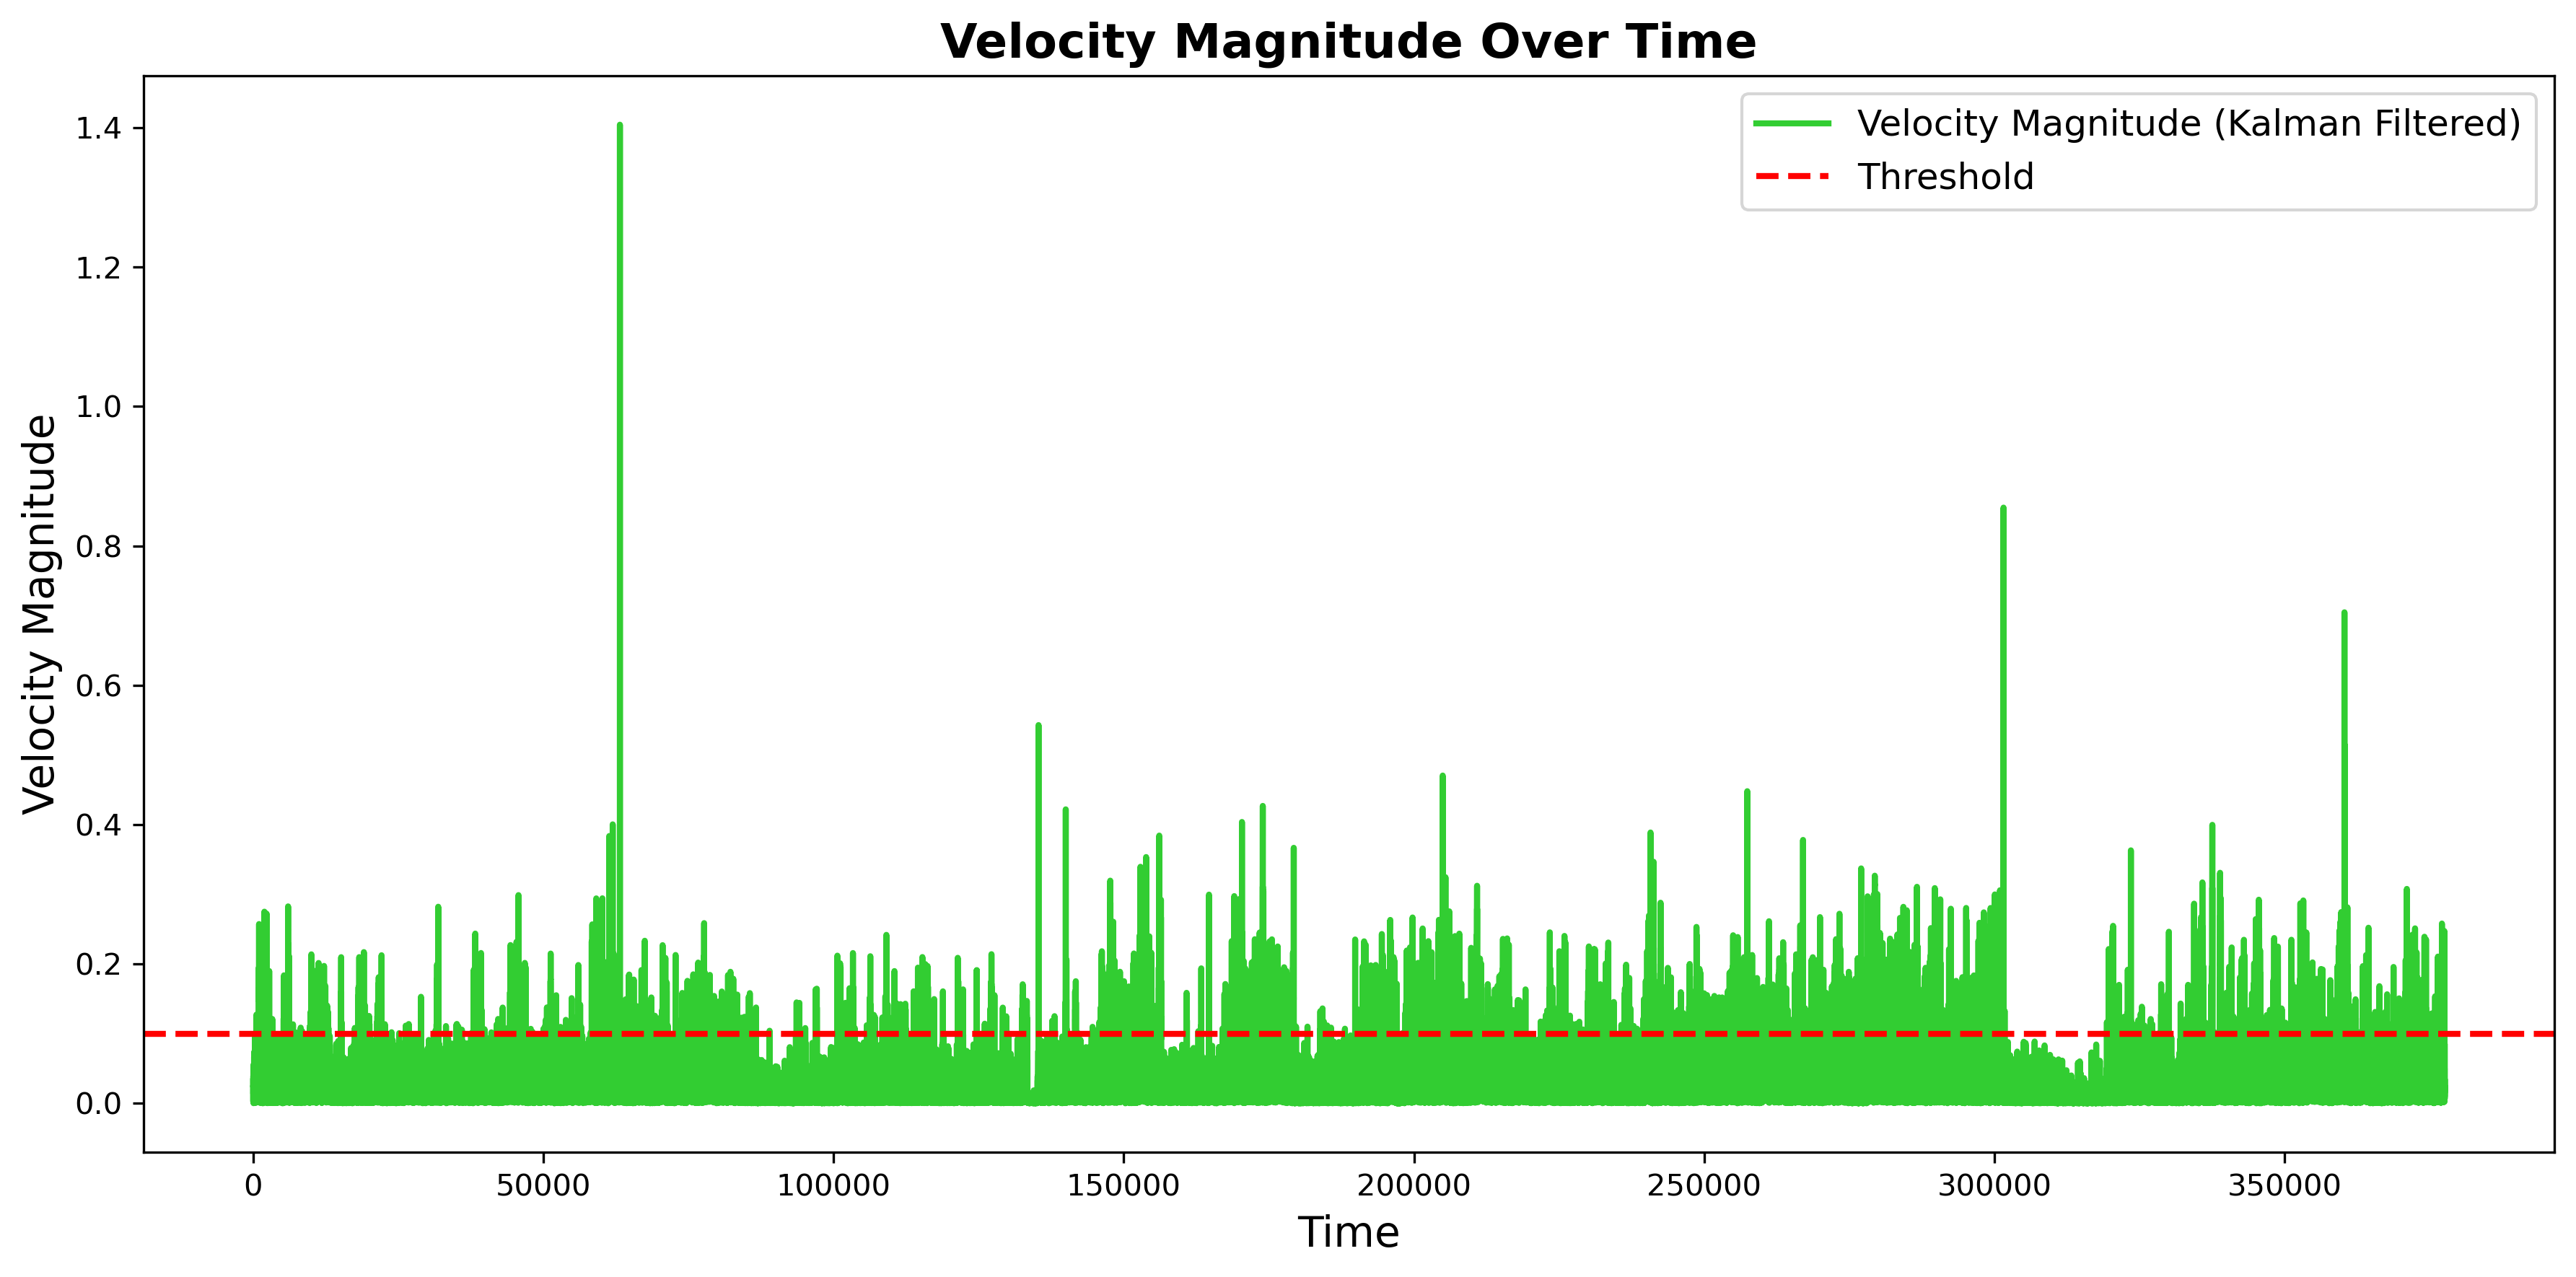

In [12]:
# Plot the velocity magnitude over time
plt.figure(figsize=(12, 6), dpi=300)  # Increase DPI for better quality
plt.plot(velocity_magnitude, label='Velocity Magnitude (Kalman Filtered)', color='#32CD32', linewidth=2)  # Green for Velocity Magnitude
plt.axhline(y=velocity_threshold, color='r', linestyle='--', label='Threshold', linewidth=2)  # Red dashed line for Threshold

# Improve title and labels
plt.title('Velocity Magnitude Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Velocity Magnitude', fontsize=14)

# Add legend with better font size
plt.legend(fontsize=12)

# Tight layout for neatness
plt.tight_layout()

# Show the plot
plt.show()